<a href="https://colab.research.google.com/github/alexfc14/Purchase-Optimization/blob/main/Simulaci%C3%B3n_y_Optimizaci%C3%B3n_de_Compras_(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalables

In [2]:
import os
os.system("sudo apt-get install -y glpk-utils")
os.system("pip install gurobipy pulp pandas")

0

# Greedy forward

Solución casi instantanea per de no muy buena calidad (+25% costo)

Numpy y pandas ya están instalados. ¡Excelente!
Iniciando la ejecución de todas las pruebas unitarias y el problema general...

       Ejecutando Pruebas Unitarias del Modelo

--- TEST: Demanda y Precio Variables ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue respetada.

--- Validación completada. ---

✓ Test Demanda y Precio Variables: PASADO.

--- TEST: Proveedor Mayorista ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue respetada.

--- Validación completada. ---

✓ Test Proveedor Mayorista: PASADO.

--- TEST: Capacidad de Almacenamiento Cero ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue

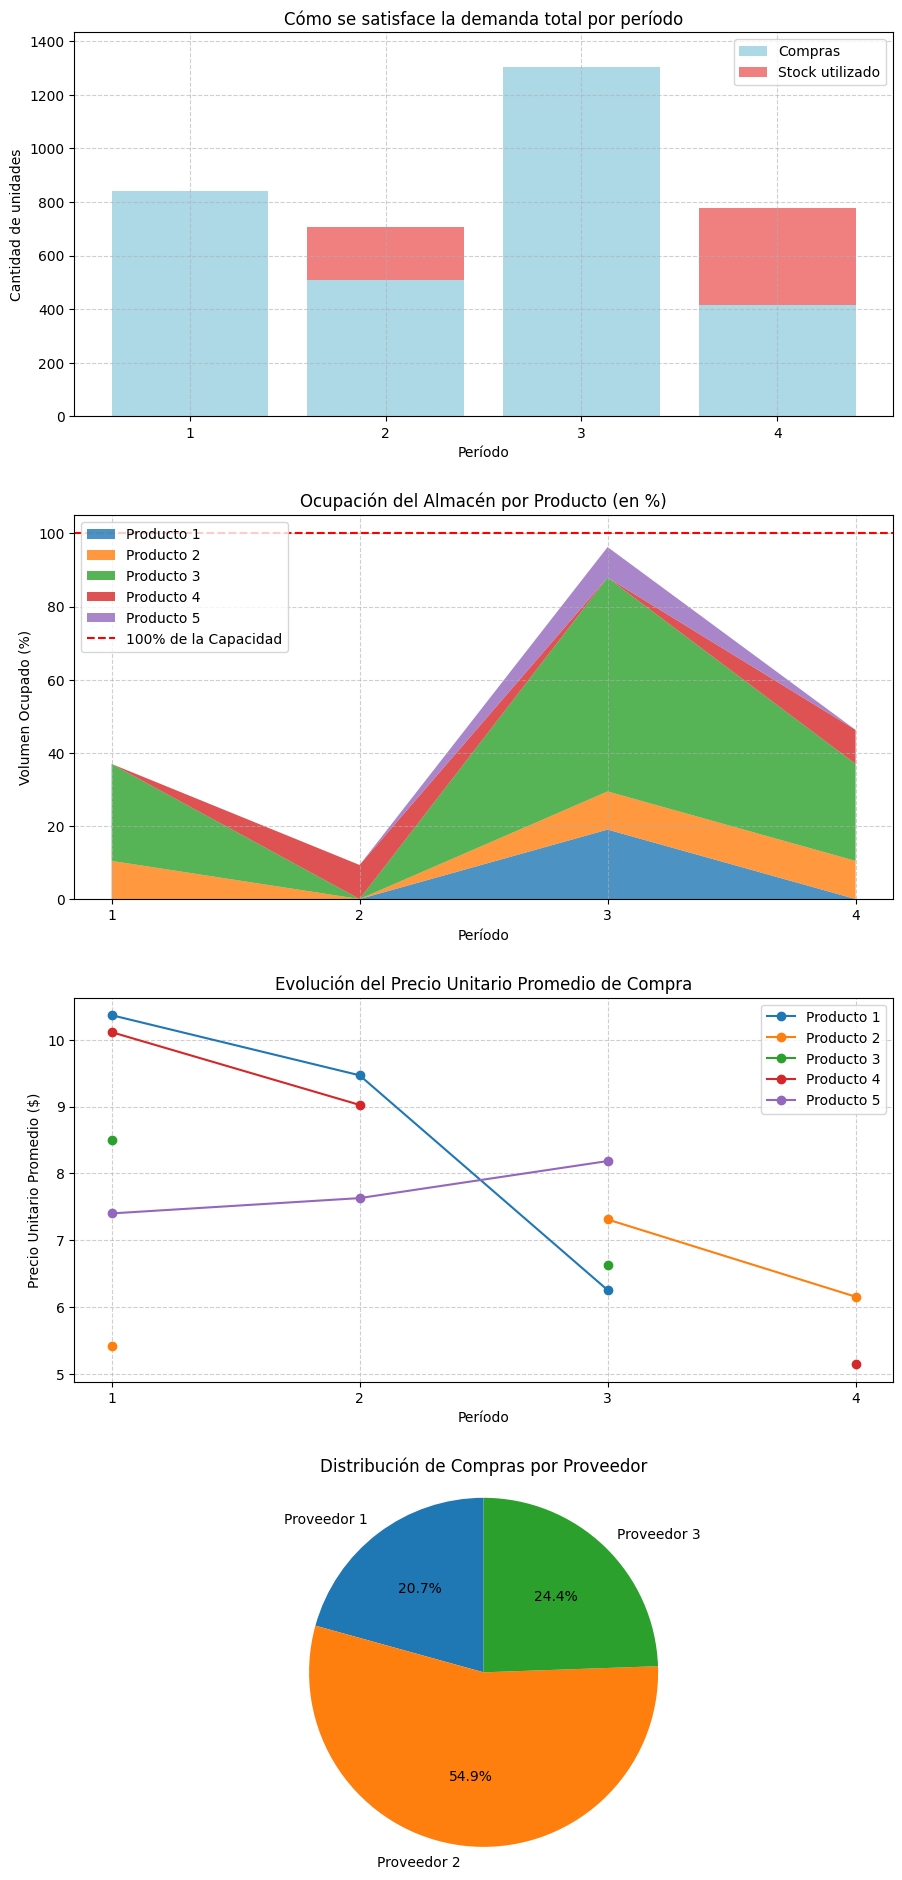

In [47]:
# ----------------------------------------------------------------------------------
# Script que implementa un algoritmo voraz para resolver un problema de
# optimización de compras y gestión de inventario, esta vez avanzando
# en el tiempo desde el primer período.
#
# Se han añadido pruebas unitarias para validar el comportamiento del
# algoritmo en escenarios de prueba específicos.
# ----------------------------------------------------------------------------------

# 1. Instalación de librerías
import numpy as np
import pandas as pd
import sys
import os
import time
import matplotlib.pyplot as plt

try:
    print("Numpy y pandas ya están instalados. ¡Excelente!")
except ImportError:
    try:
        print("Librerías no encontradas. Intentando instalar...")
        os.system("pip install numpy pandas")
    except Exception as e:
        print(f"Error al instalar las dependencias. Por favor, revisa el mensaje de error: {e}", file=sys.stderr)
        sys.exit(1)

# ----------------------------------------------------------------------------------
# 2. Clases del Modelo de Optimización y de la Solución
# ----------------------------------------------------------------------------------

class ProblemParameters:
    """
    Clase para almacenar todos los datos y parámetros del problema de optimización.
    """
    def __init__(self, K: int, M: int, T: int):
        self.K = K  # Número de productos
        self.M = M  # Número de proveedores
        self.T = T  # Número de períodos de tiempo
        self.D = None                     # Matriz de demanda D[i][t]
        self.S_0 = None                   # Vector de stock inicial S_0[i]
        self.costo_compra = None          # Tensor de costo de compra C[i][j][t]
        self.costo_almacenamiento = None  # Vector de costo de almacenamiento H[i]
        self.min_order = None             # Matriz de cantidad mínima de pedido min_p[i][j]
        self.max_order = None             # Matriz de cantidad máxima de pedido max_p[i][j]
        self.volumen_unitario = None      # Vector de volumen por unidad V[i]
        self.C_cap = None                 # Capacidad total del almacén C_cap
        self.fixed_order_cost = None      # Costo fijo por proveedor (dimensión M)
        self.supplier_capacity = None     # Capacidad máxima del proveedor [i][j][t]

    def simulate_data(self, seed: int = 42):
        """Genera datos aleatorios para el problema."""
        np.random.seed(seed)
        # Se asegura que las dimensiones definidas en __init__ se utilicen
        self.D = np.random.randint(50, 200, size=(self.K, self.T))
        self.S_0 = np.zeros(self.K)
        self.costo_compra = np.random.uniform(5, 20, size=(self.K, self.M, self.T))
        self.costo_almacenamiento = np.random.uniform(0.5, 2, size=self.K)
        self.min_order = np.random.randint(10, 20, size=(self.K, self.M))
        self.max_order = np.random.randint(200, 400, size=(self.K, self.M))
        self.volumen_unitario = np.random.uniform(0.1, 0.5, size=self.K)
        self.C_cap = 250
        # Costo fijo por proveedor (dimensión corregida)
        self.fixed_order_cost = np.random.randint(20, 100, size=self.M)
        self.supplier_capacity = np.random.randint(500, 1000, size=(self.K, self.M, self.T))

class ForwardGreedySolver:
    """
    Clase para resolver el problema de optimización de compras usando un
    algoritmo voraz que avanza en el tiempo.
    """
    def __init__(self, params: ProblemParameters):
        self.params = params
        self.purchases = np.zeros((params.K, params.M, params.T))
        # Flag de pedido realizado por proveedor y período
        self.purchase_made_flags = np.zeros((params.M, params.T), dtype=bool)

    def solve(self):
        """
        Ejecuta el algoritmo voraz hacia adelante para encontrar una solución.
        """
        supplier_capacity_left = np.copy(self.params.supplier_capacity)

        # Iniciar con el stock inicial
        current_stock = np.copy(self.params.S_0)

        # Iterar a través de los períodos de tiempo en orden cronológico
        for t in range(self.params.T):
            # Calcular la demanda neta (demanda total - stock disponible)
            net_demand = np.copy(self.params.D[:,t]) - current_stock

            # Ordenar productos por demanda neta (más demandado primero)
            product_order = np.argsort(net_demand)[::-1]

            for i in product_order:
                remaining_demand = net_demand[i]

                # Satisfacer la demanda restante solo si es positiva
                while remaining_demand > 1e-6:

                    # Encontrar el mejor candidato (proveedor y período de compra)
                    best_candidate = self._find_best_candidate(i, t, remaining_demand, supplier_capacity_left)

                    if not best_candidate:
                        print(f"ADVERTENCIA: No se pudo satisfacer la demanda del producto {i+1} en el período {t+1}.")
                        break

                    j, tau, purchase_quantity = best_candidate

                    # Realizar la compra y actualizar el estado
                    self.purchases[i, j, tau] += purchase_quantity
                    supplier_capacity_left[i, j, tau] -= purchase_quantity

                    remaining_demand -= purchase_quantity

            # Actualizar el stock para el siguiente período
            current_stock = current_stock + np.sum(self.purchases[:,:,t], axis=1) - self.params.D[:,t]

        # Calcular los niveles de stock y el costo total en un segundo paso
        stock_levels = np.zeros((self.params.K, self.params.T))
        total_cost = 0

        for t in range(self.params.T):
            if t == 0:
                stock_at_start = self.params.S_0
            else:
                stock_at_start = stock_levels[:, t-1]

            # Stock al final del período = stock inicial + compras - demanda
            stock_at_end = stock_at_start + self.purchases[:,:,t].sum(axis=1) - self.params.D[:,t]
            stock_levels[:, t] = stock_at_end

            # Calcular costos
            for i in range(self.params.K):
                # Asegurar que el stock no sea negativo para el cálculo del costo de almacenamiento
                total_cost += max(0, stock_levels[i, t]) * self.params.costo_almacenamiento[i]

            for j in range(self.params.M):
                # Sumar el costo fijo una sola vez por proveedor y período
                if np.sum(self.purchases[:,j,t]) > 1e-6 and not self.purchase_made_flags[j,t]:
                    total_cost += self.params.fixed_order_cost[j]
                    self.purchase_made_flags[j,t] = True

            # Costo de compra de los productos
            for i in range(self.params.K):
                for j in range(self.params.M):
                    total_cost += self.purchases[i, j, t] * self.params.costo_compra[i, j, t]

        return Solution(self.purchases, stock_levels, total_cost, self.params)

    def _find_best_candidate(self, i, t, remaining_demand, supplier_capacity_left):
        """
        Busca el mejor candidato (proveedor, período) para satisfacer la demanda
        de un producto en un período específico, considerando compras anticipadas.
        """
        best_unit_cost = float('inf')
        best_candidate = None

        # Iterar a través de los períodos de compra disponibles (del pasado al presente)
        for tau in range(t + 1):
            # Iterar a través de los proveedores
            for j in range(self.params.M):

                # Descartar proveedores sin capacidad restante
                if supplier_capacity_left[i, j, tau] <= 1e-6:
                    continue

                # Calcular la cantidad que se podría comprar, respetando los límites
                available_quantity = min(remaining_demand, supplier_capacity_left[i, j, tau], self.params.max_order[i, j])

                # Respetar el pedido mínimo
                if available_quantity < self.params.min_order[i, j]:
                    if self.params.min_order[i, j] <= supplier_capacity_left[i, j, tau] and remaining_demand >= self.params.min_order[i, j]:
                        available_quantity = self.params.min_order[i, j]
                    else:
                        continue

                # Calcular el costo unitario
                costo_almacenamiento_total = self.params.costo_almacenamiento[i] * (t - tau)
                costo_unitario = self.params.costo_compra[i, j, tau] + costo_almacenamiento_total

                # Sumar el costo fijo prorrateado solo si es la primera compra a este proveedor en este período
                if not self.purchase_made_flags[j, tau]:
                    # El costo fijo ahora es de una sola dimensión (por proveedor)
                    costo_unitario += self.params.fixed_order_cost[j] / available_quantity

                if costo_unitario < best_unit_cost:
                    best_unit_cost = costo_unitario
                    best_candidate = (j, tau, available_quantity)

        return best_candidate

class Solution:
    """
    Clase para almacenar, presentar y validar los resultados de una solución voraz.
    """
    def __init__(self, purchases, stock_levels, total_cost, params):
        self.purchases = purchases
        self.stock_levels = stock_levels
        self.total_cost = total_cost
        self.params = params
        self._validate_solution()

    def _validate_solution(self):
        """Ejecuta todas las pruebas de validación."""
        print("\n--- Validando la solución... ---\n")
        self._validate_all_demand_satisfied()
        self._validate_warehouse_capacity()
        self._validate_min_order()
        self._validate_supplier_capacity()
        print("\n--- Validación completada. ---\n")

    def _validate_all_demand_satisfied(self):
        """Verifica que toda la demanda fue satisfecha."""
        final_stock_calculated = self.params.S_0 + np.sum(self.purchases, axis=(1, 2)) - np.sum(self.params.D, axis=1)
        is_demand_satisfied = np.all(final_stock_calculated >= -1e-6)
        assert is_demand_satisfied, "ERROR: No toda la demanda fue satisfecha."
        print("✓ Toda la demanda fue satisfecha.")

    def _validate_warehouse_capacity(self):
        """Verifica que la capacidad del almacén no se excedió."""
        for t in range(self.params.T):
            total_volume = sum(self.stock_levels[i, t] * self.params.volumen_unitario[i] for i in range(self.params.K))
            assert total_volume <= self.params.C_cap + 1e-6, f"ERROR: Capacidad del almacén excedida en el período {t+1}."
        print("✓ La capacidad del almacén fue respetada.")

    def _validate_min_order(self):
        """Verifica que se respetó el pedido mínimo."""
        for i in range(self.params.K):
            for j in range(self.params.M):
                for t in range(self.params.T):
                    if self.purchases[i, j, t] > 1e-6:
                        assert self.purchases[i, j, t] >= self.params.min_order[i, j] - 1e-6, f"ERROR: Pedido mínimo no cumplido para (producto {i+1}, proveedor {j+1}, período {t+1})."
        print("✓ El pedido mínimo fue respetado.")

    def _validate_supplier_capacity(self):
        """Verifica que la capacidad del proveedor no se excedió."""
        is_capacity_respected = np.all(self.purchases <= self.params.supplier_capacity + 1e-6)
        assert is_capacity_respected, "ERROR: La capacidad del proveedor fue excedida."
        print("✓ La capacidad del proveedor fue respetada.")

    def display(self, message: str = "Resumen de la Solución"):
        """Imprime los resultados en un formato legible y unificado."""
        print(f"\n--- {message} ---\n")

        print(f"Costo Total: ${self.total_cost:,.2f}")

        # Resumen del plan de compras
        resultados_unificados = []
        for t in range(self.params.T):
            for i in range(self.params.K):
                compras_detalle = []
                costos_detalle = []
                for j in range(self.params.M):
                    cantidad = self.purchases[i, j, t]
                    if cantidad > 1e-6:
                        compras_detalle.append(f"Pr{j+1}: {cantidad:.2f} unid.")
                        costos_detalle.append(f"Pr{j+1}: ${self.params.costo_compra[i, j, t]:.2f}")

                if not compras_detalle:
                    compras_detalle.append("Ninguna")
                    costos_detalle.append("N/A")

                stock_final = self.stock_levels[i, t]

                resultados_unificados.append({
                    'Periodo': f'T{t+1}',
                    'Producto': f'P{i+1}',
                    'Demanda': self.params.D[i, t],
                    'Compras': "\n".join(compras_detalle),
                    'Stock Final': f"{stock_final:.2f}",
                    'Costo Unitario Compra': "\n".join(costos_detalle)
                })

        df_resultados = pd.DataFrame(resultados_unificados)
        print("\nResumen del Plan de Compras y Almacenamiento:")
        print(df_resultados.to_string(index=False))

    def plot_results(self):
        """Genera y muestra gráficos de la solución."""
        print("\n--- Generando gráficos de la solución... ---")
        fig, axes = plt.subplots(4, 1, figsize=(10, 20))
        fig.tight_layout(pad=5.0)

        # Gráfico 1: Demanda satisfecha por Compras y Stock
        periods = np.arange(1, self.params.T + 1)
        total_demand = self.params.D.sum(axis=0)
        total_purchases_per_period = self.purchases.sum(axis=(0, 1))

        # El stock utilizado es la demanda que no se cubrió con compras
        stock_used_per_period = total_demand - total_purchases_per_period

        # Se asegura que el stock usado no sea negativo (lo que indicaría un problema de datos o lógica)
        stock_used_per_period = np.maximum(stock_used_per_period, 0)

        ax1 = axes[0]
        ax1.bar(periods, total_purchases_per_period, label='Compras', color='lightblue')
        ax1.bar(periods, stock_used_per_period, bottom=total_purchases_per_period, label='Stock utilizado', color='lightcoral')

        ax1.set_title('Cómo se satisface la demanda total por período')
        ax1.set_xlabel('Período')
        ax1.set_ylabel('Cantidad de unidades')
        ax1.set_xticks(periods)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Ajuste del límite superior del eje Y para evitar que las barras se corten
        max_demand_to_plot = (total_purchases_per_period + stock_used_per_period).max()
        ax1.set_ylim(0, max_demand_to_plot * 1.1)


        # Gráfico 2: Evolución del Volumen de Almacenamiento Apilado por Producto (en porcentaje)
        ax2 = axes[1]
        volume_by_product = self.stock_levels * self.params.volumen_unitario[:, np.newaxis]
        volume_by_product_T = volume_by_product.T
        percentage_volume = (volume_by_product_T / self.params.C_cap) * 100
        labels = [f'Producto {i+1}' for i in range(self.params.K)]
        ax2.stackplot(np.arange(1, self.params.T + 1), percentage_volume.T, labels=labels, alpha=0.8)
        ax2.axhline(y=100, color='r', linestyle='--', label='100% de la Capacidad')
        ax2.set_title('Ocupación del Almacén por Producto (en %)')
        ax2.set_xlabel('Período')
        ax2.set_ylabel('Volumen Ocupado (%)')
        ax2.set_xticks(np.arange(1, self.params.T + 1))
        ax2.legend(loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.set_ylim(0, 105)

        # Gráfico 3: Precio Unitario Promedio por Producto y Período
        ax3 = axes[2]
        avg_unit_prices = np.full((self.params.K, self.params.T), np.nan)
        for i in range(self.params.K):
            for t in range(self.params.T):
                total_purchased_quantity = np.sum(self.purchases[i, :, t])
                if total_purchased_quantity > 1e-6:
                    total_purchase_cost = np.sum(self.purchases[i, :, t] * self.params.costo_compra[i, :, t])
                    avg_unit_prices[i, t] = total_purchase_cost / total_purchased_quantity

        for i in range(self.params.K):
            ax3.plot(np.arange(1, self.params.T + 1), avg_unit_prices[i, :], label=f'Producto {i+1}', marker='o')

        ax3.set_title('Evolución del Precio Unitario Promedio de Compra')
        ax3.set_xlabel('Período')
        ax3.set_ylabel('Precio Unitario Promedio ($)')
        ax3.set_xticks(np.arange(1, self.params.T + 1))
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.6)

        # Gráfico 4: Compras Totales por Proveedor (Gráfico de Tarta)
        ax4 = axes[3]
        total_purchases_by_supplier = self.purchases.sum(axis=0).sum(axis=1)
        supplier_labels = [f'Proveedor {j+1}' for j in range(self.params.M)]

        if np.sum(total_purchases_by_supplier) > 1e-6:
            ax4.pie(total_purchases_by_supplier, labels=supplier_labels, autopct='%1.1f%%', startangle=90)
            ax4.set_title('Distribución de Compras por Proveedor')
            ax4.axis('equal')
        else:
            ax4.text(0.5, 0.5, "No hubo compras totales a proveedores.",
                     ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Distribución de Compras por Proveedor')
            ax4.axis('off')

        plt.show()


# ----------------------------------------------------------------------------------
# 3. Pruebas unitarias
# ----------------------------------------------------------------------------------
def test_variable_demand_and_price():
    """Test para un escenario con demanda y precio variables, favoreciendo la compra anticipada."""
    print("\n--- TEST: Demanda y Precio Variables ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[10, 100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 50]]])
    params.costo_almacenamiento = np.array([1])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    params.fixed_order_cost = np.array([0])
    params.supplier_capacity = np.array([[[500, 500]]])

    solver = ForwardGreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    # El algoritmo voraz con avance en el tiempo debería comprar toda la demanda futura
    # en el primer período, ya que el costo es mucho menor.
    assert abs(sol.purchases[0, 0, 0] - 110) < 1e-6, f"La primera compra no es la esperada (110 unidades): {sol.purchases[0, 0, 0]}"
    assert abs(sol.purchases[0, 0, 1] - 0) < 1e-6, f"La segunda compra no es la esperada (0 unidades): {sol.purchases[0, 0, 1]}"
    print("✓ Test Demanda y Precio Variables: PASADO.")

def test_wholesale_vs_standard_supplier():
    """Test para un escenario con un proveedor mayorista con pedido mínimo alto."""
    print("\n--- TEST: Proveedor Mayorista ---")
    params = ProblemParameters(K=1, M=2, T=1)
    params.D = np.array([[100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[2.0], [5.0]]])
    params.costo_almacenamiento = np.array([0])
    params.min_order = np.array([[1000, 10]])
    params.max_order = np.array([[1000, 100]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    # Costo fijo por proveedor (dimensión corregida)
    params.fixed_order_cost = np.array([10, 10])
    params.supplier_capacity = np.array([[[1000], [100]]])

    solver = ForwardGreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    # El algoritmo hacia adelante elegirá el proveedor 2
    assert abs(sol.purchases[0, 0, 0]) < 1e-6
    assert abs(sol.purchases[0, 1, 0] - params.D[0,0]) < 1e-6
    print("✓ Test Proveedor Mayorista: PASADO.")

def test_zero_storage_capacity():
    """Test para un escenario sin capacidad de almacenamiento."""
    print("\n--- TEST: Capacidad de Almacenamiento Cero ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[100, 150]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 10]]])
    params.costo_almacenamiento = np.array([100])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 0
    # Costo fijo por proveedor (dimensión corregida)
    params.fixed_order_cost = np.array([1])
    params.supplier_capacity = np.array([[[500, 500]]])

    solver = ForwardGreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert abs(sol.purchases[0, 0, 0] - params.D[0, 0]) < 1e-6
    assert abs(sol.purchases[0, 0, 1] - params.D[0, 1]) < 1e-6
    assert abs(sol.stock_levels[0, 0]) < 1e-6
    print("✓ Test Capacidad de Almacenamiento Cero: PASADO.")


def test_liquidation_scenario():
    """Test para un escenario con stock inicial que satisface la demanda."""
    print("\n--- TEST: Escenario de Liquidación ---")
    params = ProblemParameters(K=1, M=1, T=1)
    params.D = np.array([[50]])
    params.S_0 = np.array([50])
    params.costo_compra = np.array([[[10]]])
    params.costo_almacenamiento = np.array([1])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    # Costo fijo por proveedor (dimensión corregida)
    params.fixed_order_cost = np.array([1])
    params.supplier_capacity = np.array([[[500]]])

    solver = ForwardGreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert abs(sol.purchases[0, 0, 0]) < 1e-6
    assert abs(sol.stock_levels[0, 0]) < 1e-6
    print("✓ Test Escenario de Liquidación: PASADO.")

def run_performance_test():
    """
    Realiza una prueba de rendimiento del modelo a gran escala.
    """
    num_products, num_providers, num_periods = 10, 10, 10
    print(f"\n--- TEST DE RENDIMIENTO: {num_products} productos, {num_providers} proveedores, {num_periods} períodos ---")
    try:
        params = ProblemParameters(num_products, num_providers, num_periods)
        params.simulate_data(seed=42) # Usar una semilla diferente
        solver = ForwardGreedySolver(params)

        start_time = time.time()
        sol = solver.solve()
        end_time = time.time()

        if sol:
            print(f"✓ TEST DE RENDIMIENTO: Finalizado en {end_time - start_time:.4f} segundos.")
            # sol.display(message="Resumen del Test de Rendimiento")
        else:
            print(f"✖ TEST DE RENDIMIENTO FALLIDO: No se encontró solución.")
    except Exception as e:
        print(f"✖ TEST DE RENDIMIENTO FALLIDO: Error durante la ejecución - {e}")

def run_all_tests():
    """Ejecuta todos los tests unitarios y la prueba de rendimiento."""
    print("\n==============================================")
    print("       Ejecutando Pruebas Unitarias del Modelo")
    print("==============================================")
    test_variable_demand_and_price()
    test_wholesale_vs_standard_supplier()
    test_zero_storage_capacity()
    test_liquidation_scenario()

    print("\n==============================================")
    print("          Iniciando Prueba de Rendimiento")
    print("==============================================")
    run_performance_test()
    print("\n==============================================")
    print("      Todas las pruebas han finalizado.")
    print("==============================================\n")

# ----------------------------------------------------------------------------------
# 4. Ejecución principal
# ----------------------------------------------------------------------------------
if __name__ == '__main__':
    print("Iniciando la ejecución de todas las pruebas unitarias y el problema general...")

    # Ejecutar todas las pruebas unitarias para un sanity check
    run_all_tests()

    print("\n==============================================")
    print("  Ejecutando problema general con K=5, M=3, T=4")
    print("==============================================")
    # Ejecutar el problema general con las dimensiones especificadas
    params_general = ProblemParameters(K=5, M=3, T=4)
    params_general.simulate_data(seed=123)

    solver_general = ForwardGreedySolver(params_general)
    solution_general = solver_general.solve()
    solution_general.display()
    solution_general.plot_results()

# Greedy backwards

Solución muy rápida, +10% costo

Numpy y pandas ya están instalados. ¡Excelente!
Iniciando la ejecución de todas las pruebas unitarias y el problema general...

       Ejecutando Pruebas Unitarias del Modelo

--- TEST: Demanda y Precio Variables ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue respetada.

--- Validación completada. ---

✓ Test Demanda y Precio Variables: PASADO.

--- TEST: Proveedor Mayorista ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue respetada.

--- Validación completada. ---

✓ Test Proveedor Mayorista: PASADO.

--- TEST: Capacidad de Almacenamiento Cero ---

--- Validando la solución... ---

✓ Toda la demanda fue satisfecha.
✓ La capacidad del almacén fue respetada.
✓ El pedido mínimo fue respetado.
✓ La capacidad del proveedor fue

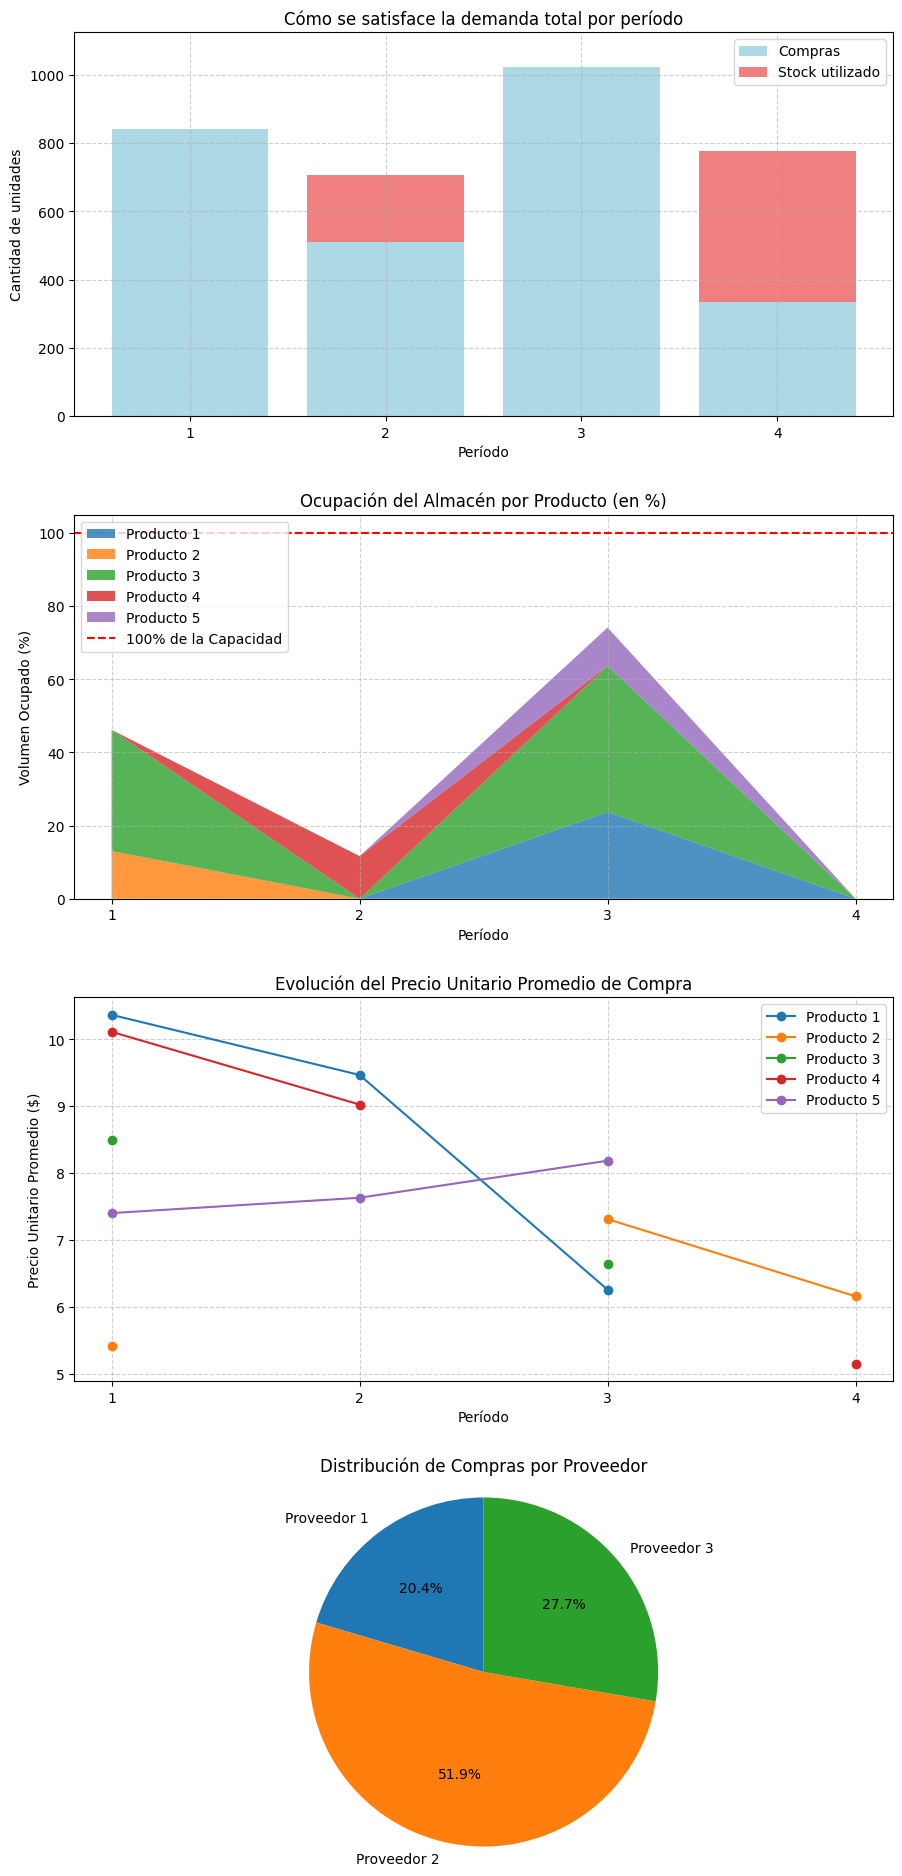

In [50]:
# ----------------------------------------------------------------------------------
# Script que implementa un algoritmo voraz para resolver un problema de
# optimización de compras y gestión de inventario.
#
# Se han añadido pruebas unitarias para validar el comportamiento del
# algoritmo en escenarios de prueba específicos.
# ----------------------------------------------------------------------------------

# 1. Instalación de librerías
import numpy as np
import pandas as pd
import sys
import os
import time

try:
    print("Numpy y pandas ya están instalados. ¡Excelente!")
except ImportError:
    try:
        print("Librerías no encontradas. Intentando instalar...")
        os.system("pip install numpy pandas")
    except Exception as e:
        print(f"Error al instalar las dependencias. Por favor, revisa el mensaje de error: {e}", file=sys.stderr)
        sys.exit(1)

# ----------------------------------------------------------------------------------
# 2. Clases del Modelo de Optimización y de la Solución
# ----------------------------------------------------------------------------------

class ProblemParameters:
    """
    Clase para almacenar todos los datos y parámetros del problema de optimización.
    """
    def __init__(self, K: int, M: int, T: int):
        self.K = K  # Número de productos
        self.M = M  # Número de proveedores
        self.T = T  # Número de períodos de tiempo
        self.D = None                     # Matriz de demanda D[i][t]
        self.S_0 = None                     # Vector de stock inicial S_0[i]
        self.costo_compra = None          # Tensor de costo de compra C[i][j][t]
        self.costo_almacenamiento = None  # Vector de costo de almacenamiento H[i]
        self.min_order = None             # Matriz de cantidad mínima de pedido min_p[i][j]
        self.max_order = None             # Matriz de cantidad máxima de pedido max_p[i][j]
        self.volumen_unitario = None      # Vector de volumen por unidad V[i]
        self.C_cap = None                 # Capacidad total del almacén C_cap
        self.fixed_order_cost = None      # Costo fijo por realizar un pedido
        self.supplier_capacity = None     # Capacidad máxima del proveedor [i][j][t]

    def simulate_data(self, seed: int = 42):
        """Genera datos aleatorios para el problema."""
        np.random.seed(seed)
        # Se asegura que las dimensiones definidas en __init__ se utilicen
        self.D = np.random.randint(50, 200, size=(self.K, self.T))
        self.S_0 = np.zeros(self.K)
        self.costo_compra = np.random.uniform(5, 20, size=(self.K, self.M, self.T))
        self.costo_almacenamiento = np.random.uniform(0.5, 2, size=self.K)
        self.min_order = np.random.randint(10, 20, size=(self.K, self.M))
        self.max_order = np.random.randint(200, 400, size=(self.K, self.M))
        self.volumen_unitario = np.random.uniform(0.1, 0.5, size=self.K)
        self.C_cap = 200
        # El costo fijo ahora es por proveedor (dimensión M).
        self.fixed_order_cost = np.random.randint(20, 100, size=self.M)
        self.supplier_capacity = np.random.randint(500, 1000, size=(self.K, self.M, self.T))

class GreedySolver:
    """
    Clase para resolver el problema de optimización de compras usando un
    algoritmo voraz.
    """
    def __init__(self, params: ProblemParameters):
        self.params = params
        self.purchases = np.zeros((params.K, params.M, params.T))

    def solve(self):
        """
        Ejecuta el algoritmo voraz para encontrar una solución.
        """
        supplier_capacity_left = np.copy(self.params.supplier_capacity)

        # Ajustar la demanda del primer período con el stock inicial
        effective_demand = np.copy(self.params.D)
        for i in range(self.params.K):
            effective_demand[i, 0] = max(0, effective_demand[i, 0] - self.params.S_0[i])

        # Iterar a través de los períodos de tiempo en orden inverso
        for t in range(self.params.T - 1, -1, -1):

            # Ordenar productos por demanda en el período actual (más demandado primero)
            product_order = np.argsort(effective_demand[:, t])[::-1]

            for i in product_order:
                remaining_demand = effective_demand[i, t]

                # Satisfacer la demanda restante
                while remaining_demand > 1e-6:

                    # Encontrar el mejor candidato (proveedor y período)
                    best_candidate = self._find_best_candidate(i, t, remaining_demand, supplier_capacity_left)

                    if not best_candidate:
                        print(f"ADVERTENCIA: No se pudo satisfacer toda la demanda del producto {i+1} en el período {t+1}.")
                        break # Salir del bucle si no hay más opciones

                    j, tau, purchase_quantity = best_candidate

                    # Realizar la compra y actualizar el estado
                    self.purchases[i, j, tau] += purchase_quantity
                    supplier_capacity_left[i, j, tau] -= purchase_quantity

                    remaining_demand -= purchase_quantity

        # Calcular los niveles de stock y el costo total en un segundo paso
        stock_levels = np.zeros((self.params.K, self.params.T))
        total_cost = 0

        for t in range(self.params.T):
            if t == 0:
                stock_at_start = self.params.S_0
            else:
                stock_at_start = stock_levels[:, t-1]

            # Stock al final del período = stock inicial + compras - demanda
            stock_at_end = stock_at_start + self.purchases[:,:,t].sum(axis=1) - self.params.D[:,t]
            stock_levels[:, t] = stock_at_end

            for i in range(self.params.K):
                # Costo de almacenamiento
                total_cost += max(0, stock_at_end[i]) * self.params.costo_almacenamiento[i]

            # Calcular costos de compra y fijos una vez por proveedor y período
            for j in range(self.params.M):
                purchase_quantity_from_supplier = np.sum(self.purchases[:, j, t])
                if purchase_quantity_from_supplier > 1e-6:
                    total_cost += self.params.fixed_order_cost[j]
                    for i in range(self.params.K):
                        total_cost += self.purchases[i, j, t] * self.params.costo_compra[i, j, t]

        return Solution(self.purchases, stock_levels, total_cost, self.params)

    def _find_best_candidate(self, i, t, remaining_demand, supplier_capacity_left):
        """
        Busca el mejor candidato (proveedor, período) para satisfacer la demanda
        de un producto en un período específico.
        """
        best_unit_cost = float('inf')
        best_candidate = None

        # Iterar a través de los períodos de compra disponibles (del pasado al presente)
        for tau in range(t + 1):
            # Iterar a través de los proveedores
            for j in range(self.params.M):

                # Descartar proveedores sin capacidad restante
                if supplier_capacity_left[i, j, tau] <= 1e-6:
                    continue

                # Calcular la cantidad que se podría comprar, respetando los límites
                available_quantity = min(remaining_demand, supplier_capacity_left[i, j, tau], self.params.max_order[i, j])

                # Respetar el pedido mínimo
                if available_quantity < self.params.min_order[i, j]:
                    if self.params.min_order[i, j] <= supplier_capacity_left[i, j, tau] and remaining_demand >= self.params.min_order[i, j]:
                        available_quantity = self.params.min_order[i, j]
                    else:
                        continue

                # Verificar la capacidad del almacén para los períodos de almacenamiento
                warehouse_ok = True
                if self.params.C_cap > 1e-6:
                    for period_check in range(tau, t): # Solo verificar hasta el período anterior a la demanda
                        projected_stock = self._get_projected_stock(self.purchases, period_check)
                        current_volume = np.sum(projected_stock * self.params.volumen_unitario)
                        if (current_volume + available_quantity * self.params.volumen_unitario[i]) > self.params.C_cap + 1e-6:
                            warehouse_ok = False
                            break
                if not warehouse_ok:
                    continue

                # Calcular el costo unitario
                costo_almacenamiento_total = self.params.costo_almacenamiento[i] * (t - tau)
                costo_unitario = self.params.costo_compra[i, j, tau] + costo_almacenamiento_total

                # El costo fijo se aplica si no se ha realizado ninguna compra
                # a este proveedor 'j' en el período 'tau'. Se verifica si la suma de las
                # compras de todos los productos de este proveedor es cero.
                if np.sum(self.purchases[:, j, tau]) < 1e-6:
                    costo_unitario += self.params.fixed_order_cost[j] / available_quantity

                if costo_unitario < best_unit_cost:
                    best_unit_cost = costo_unitario
                    best_candidate = (j, tau, available_quantity)

        return best_candidate

    def _get_projected_stock(self, purchases, period):
        """Calcula el stock proyectado al final de un período dado."""
        stock = np.array(self.params.S_0, dtype=float)

        for t_p in range(period + 1):
            stock += np.sum(purchases[:,:,t_p], axis=1) - self.params.D[:,t_p]

        return stock

class Solution:
    """
    Clase para almacenar, presentar y validar los resultados de una solución voraz.
    """
    def __init__(self, purchases, stock_levels, total_cost, params):
        self.purchases = purchases
        self.stock_levels = stock_levels
        self.total_cost = total_cost
        self.params = params
        self._validate_solution()

    def _validate_solution(self):
        """Ejecuta todas las pruebas de validación."""
        print("\n--- Validando la solución... ---\n")
        self._validate_all_demand_satisfied()
        self._validate_warehouse_capacity()
        self._validate_min_order()
        self._validate_supplier_capacity()
        print("\n--- Validación completada. ---\n")

    def _validate_all_demand_satisfied(self):
        """Verifica que toda la demanda fue satisfecha."""
        final_stock_calculated = self.params.S_0 + np.sum(self.purchases, axis=(1, 2)) - np.sum(self.params.D, axis=1)
        is_demand_satisfied = np.all(final_stock_calculated >= -1e-6)
        assert is_demand_satisfied, "ERROR: No toda la demanda fue satisfecha."
        print("✓ Toda la demanda fue satisfecha.")

    def _validate_warehouse_capacity(self):
        """Verifica que la capacidad del almacén no se excedió."""
        for t in range(self.params.T):
            total_volume = sum(self.stock_levels[i, t] * self.params.volumen_unitario[i] for i in range(self.params.K))
            assert total_volume <= self.params.C_cap + 1e-6, f"ERROR: Capacidad del almacén excedida en el período {t+1}."
        print("✓ La capacidad del almacén fue respetada.")

    def _validate_min_order(self):
        """Verifica que se respetó el pedido mínimo."""
        for i in range(self.params.K):
            for j in range(self.params.M):
                for t in range(self.params.T):
                    if self.purchases[i, j, t] > 1e-6:
                        assert self.purchases[i, j, t] >= self.params.min_order[i, j] - 1e-6, f"ERROR: Pedido mínimo no cumplido para (producto {i+1}, proveedor {j+1}, período {t+1})."
        print("✓ El pedido mínimo fue respetado.")

    def _validate_supplier_capacity(self):
        """Verifica que la capacidad del proveedor no se excedió."""
        is_capacity_respected = np.all(self.purchases <= self.params.supplier_capacity + 1e-6)
        assert is_capacity_respected, "ERROR: La capacidad del proveedor fue excedida."
        print("✓ La capacidad del proveedor fue respetada.")

    def display(self, message: str = "Resumen de la Solución"):
        """Imprime los resultados en un formato legible y unificado."""
        print(f"\n--- {message} ---\n")

        print(f"Costo Total: ${self.total_cost:,.2f}")

        # Resumen del plan de compras
        resultados_unificados = []
        for t in range(self.params.T):
            for i in range(self.params.K):
                compras_detalle = []
                costos_detalle = []
                for j in range(self.params.M):
                    cantidad = self.purchases[i, j, t]
                    if cantidad > 1e-6:
                        compras_detalle.append(f"Pr{j+1}: {cantidad:.2f} u")
                        costos_detalle.append(f"Pr{j+1}: ${self.params.costo_compra[i, j, t]:.2f}")

                if not compras_detalle:
                    compras_detalle.append("Ninguna")
                    costos_detalle.append("N/A")

                stock_final = self.stock_levels[i, t]

                resultados_unificados.append({
                    'Periodo': f'T{t+1}',
                    'Producto': f'P{i+1}',
                    'Demanda': self.params.D[i, t],
                    'Compras': "\n".join(compras_detalle),
                    'Stock Final': f"{stock_final:.2f}",
                    'Costo Unitario Compra': "\n".join(costos_detalle)
                })

        df_resultados = pd.DataFrame(resultados_unificados)
        print("\nResumen del Plan de Compras y Almacenamiento:")
        print(df_resultados.to_string(index=False))

    def plot_results(self):
        """Genera y muestra gráficos de la solución."""
        print("\n--- Generando gráficos de la solución... ---")
        fig, axes = plt.subplots(4, 1, figsize=(10, 20))
        fig.tight_layout(pad=5.0)

        # Gráfico 1: Demanda satisfecha por Compras y Stock
        periods = np.arange(1, self.params.T + 1)
        total_demand = self.params.D.sum(axis=0)
        total_purchases_per_period = self.purchases.sum(axis=(0, 1))

        # El stock utilizado es la demanda que no se cubrió con compras
        stock_used_per_period = total_demand - total_purchases_per_period

        # Se asegura que el stock usado no sea negativo (lo que indicaría un problema de datos o lógica)
        stock_used_per_period = np.maximum(stock_used_per_period, 0)

        ax1 = axes[0]
        ax1.bar(periods, total_purchases_per_period, label='Compras', color='lightblue')
        ax1.bar(periods, stock_used_per_period, bottom=total_purchases_per_period, label='Stock utilizado', color='lightcoral')

        ax1.set_title('Cómo se satisface la demanda total por período')
        ax1.set_xlabel('Período')
        ax1.set_ylabel('Cantidad de unidades')
        ax1.set_xticks(periods)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Ajuste del límite superior del eje Y para evitar que las barras se corten
        max_demand_to_plot = (total_purchases_per_period + stock_used_per_period).max()
        ax1.set_ylim(0, max_demand_to_plot * 1.1)


        # Gráfico 2: Evolución del Volumen de Almacenamiento Apilado por Producto (en porcentaje)
        ax2 = axes[1]
        volume_by_product = self.stock_levels * self.params.volumen_unitario[:, np.newaxis]
        volume_by_product_T = volume_by_product.T
        percentage_volume = (volume_by_product_T / self.params.C_cap) * 100
        labels = [f'Producto {i+1}' for i in range(self.params.K)]
        ax2.stackplot(np.arange(1, self.params.T + 1), percentage_volume.T, labels=labels, alpha=0.8)
        ax2.axhline(y=100, color='r', linestyle='--', label='100% de la Capacidad')
        ax2.set_title('Ocupación del Almacén por Producto (en %)')
        ax2.set_xlabel('Período')
        ax2.set_ylabel('Volumen Ocupado (%)')
        ax2.set_xticks(np.arange(1, self.params.T + 1))
        ax2.legend(loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.set_ylim(0, 105)

        # Gráfico 3: Precio Unitario Promedio por Producto y Período
        ax3 = axes[2]
        avg_unit_prices = np.full((self.params.K, self.params.T), np.nan)
        for i in range(self.params.K):
            for t in range(self.params.T):
                total_purchased_quantity = np.sum(self.purchases[i, :, t])
                if total_purchased_quantity > 1e-6:
                    total_purchase_cost = np.sum(self.purchases[i, :, t] * self.params.costo_compra[i, :, t])
                    avg_unit_prices[i, t] = total_purchase_cost / total_purchased_quantity

        for i in range(self.params.K):
            ax3.plot(np.arange(1, self.params.T + 1), avg_unit_prices[i, :], label=f'Producto {i+1}', marker='o')

        ax3.set_title('Evolución del Precio Unitario Promedio de Compra')
        ax3.set_xlabel('Período')
        ax3.set_ylabel('Precio Unitario Promedio ($)')
        ax3.set_xticks(np.arange(1, self.params.T + 1))
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.6)

        # Gráfico 4: Compras Totales por Proveedor (Gráfico de Tarta)
        ax4 = axes[3]
        total_purchases_by_supplier = self.purchases.sum(axis=0).sum(axis=1)
        supplier_labels = [f'Proveedor {j+1}' for j in range(self.params.M)]

        if np.sum(total_purchases_by_supplier) > 1e-6:
            ax4.pie(total_purchases_by_supplier, labels=supplier_labels, autopct='%1.1f%%', startangle=90)
            ax4.set_title('Distribución de Compras por Proveedor')
            ax4.axis('equal')
        else:
            ax4.text(0.5, 0.5, "No hubo compras totales a proveedores.",
                     ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Distribución de Compras por Proveedor')
            ax4.axis('off')

        plt.show()

# ----------------------------------------------------------------------------------
# 3. Pruebas unitarias
# ----------------------------------------------------------------------------------
def test_variable_demand_and_price():
    """Test para un escenario con demanda y precio variables, favoreciendo la compra anticipada."""
    print("\n--- TEST: Demanda y Precio Variables ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[10, 100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 50]]])
    params.costo_almacenamiento = np.array([1])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    # Se utiliza un costo fijo de proveedor.
    params.fixed_order_cost = np.array([0])
    params.supplier_capacity = np.array([[[500, 500]]])

    solver = GreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert sol.purchases[0, 0, 0] > 1e-6
    assert abs(sol.purchases[0, 0, 1]) < 1e-6
    print("✓ Test Demanda y Precio Variables: PASADO.")

def test_wholesale_vs_standard_supplier():
    """Test para un escenario con un proveedor mayorista con pedido mínimo alto."""
    print("\n--- TEST: Proveedor Mayorista ---")
    params = ProblemParameters(K=1, M=2, T=1)
    params.D = np.array([[100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[2.0], [5.0]]])
    params.costo_almacenamiento = np.array([0])
    params.min_order = np.array([[1000, 10]])
    params.max_order = np.array([[1000, 100]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    # El costo fijo es ahora un array 1D.
    params.fixed_order_cost = np.array([10, 10])
    params.supplier_capacity = np.array([[[1000], [100]]])

    solver = GreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert abs(sol.purchases[0, 0, 0]) < 1e-6
    assert abs(sol.purchases[0, 1, 0] - params.D[0,0]) < 1e-6
    print("✓ Test Proveedor Mayorista: PASADO.")


def test_zero_storage_capacity():
    """Test para un escenario sin capacidad de almacenamiento."""
    print("\n--- TEST: Capacidad de Almacenamiento Cero ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[100, 150]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 10]]])
    params.costo_almacenamiento = np.array([100])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 0
    # Se utiliza un costo fijo de proveedor.
    params.fixed_order_cost = np.array([1, 1])
    params.supplier_capacity = np.array([[[500, 500]]])

    solver = GreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert abs(sol.purchases[0, 0, 0] - params.D[0, 0]) < 1e-6
    assert abs(sol.purchases[0, 0, 1] - params.D[0, 1]) < 1e-6
    assert abs(sol.stock_levels[0, 0]) < 1e-6
    print("✓ Test Capacidad de Almacenamiento Cero: PASADO.")


def test_liquidation_scenario():
    """Test para un escenario con stock inicial que satisface la demanda."""
    print("\n--- TEST: Escenario de Liquidación ---")
    params = ProblemParameters(K=1, M=1, T=1)
    params.D = np.array([[50]])
    params.S_0 = np.array([50])
    params.costo_compra = np.array([[[10]]])
    params.costo_almacenamiento = np.array([1])
    params.min_order = np.array([[1]])
    params.max_order = np.array([[500]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500
    # Se utiliza un costo fijo de proveedor.
    params.fixed_order_cost = np.array([1])
    params.supplier_capacity = np.array([[[500]]])

    solver = GreedySolver(params)
    sol = solver.solve()
    assert sol is not None, "La solución no debería ser nula"
    assert abs(sol.purchases[0, 0, 0]) < 1e-6
    assert abs(sol.stock_levels[0, 0]) < 1e-6
    print("✓ Test Escenario de Liquidación: PASADO.")

def run_performance_test():
    """
    Realiza una prueba de rendimiento del modelo a gran escala.
    """
    num_products, num_providers, num_periods = 10, 10, 10
    print(f"\n--- TEST DE RENDIMIENTO: {num_products} productos, {num_providers} proveedores, {num_periods} períodos ---")
    try:
        params = ProblemParameters(num_products, num_providers, num_periods)
        params.simulate_data(seed=42) # Usar una semilla diferente
        solver = GreedySolver(params)

        start_time = time.time()
        sol = solver.solve()
        end_time = time.time()

        if sol:
            print(f"✓ TEST DE RENDIMIENTO: Finalizado en {end_time - start_time:.4f} segundos.")
        else:
            print(f"✖ TEST DE RENDIMIENTO FALLIDO: No se encontró solución.")
    except Exception as e:
        print(f"✖ TEST DE RENDIMIENTO FALLIDO: Error durante la ejecución - {e}")

def run_all_tests():
    """Ejecuta todos los tests unitarios y la prueba de rendimiento."""
    print("\n==============================================")
    print("       Ejecutando Pruebas Unitarias del Modelo")
    print("==============================================")
    test_variable_demand_and_price()
    test_wholesale_vs_standard_supplier()
    test_zero_storage_capacity()
    test_liquidation_scenario()

    print("\n==============================================")
    print("           Iniciando Prueba de Rendimiento")
    print("==============================================")
    run_performance_test()
    print("\n==============================================")
    print("       Todas las pruebas han finalizado.")
    print("==============================================\n")

# ----------------------------------------------------------------------------------
# 4. Ejecución principal
# ----------------------------------------------------------------------------------
if __name__ == '__main__':
    print("Iniciando la ejecución de todas las pruebas unitarias y el problema general...")

    # Ejecutar todas las pruebas unitarias para un sanity check
    run_all_tests()

    print("\n==============================================")
    print("   Ejecutando problema general con K=5, M=3, T=4")
    print("==============================================")
    # Ejecutar el problema general con las dimensiones especificadas
    params_general = ProblemParameters(K=5, M=3, T=4)
    params_general.simulate_data(seed=123)

    solver_general = GreedySolver(params_general)
    solution_general = solver_general.solve()
    solution_general.display()
    solution_general.plot_results()


# Solución exacta con pulp + Gurobi solver

Notar que en esta solución, el pedido minimo se aplica en global al total de productos pedidos al mismo proveedor, no a nivel producto. Esto reduce drásticamente el número de restricciones, pasando de MxKxP a (M+K)xP.
Con una licencia comercial de Gurobi, se podría considerar el problema con pedido mínimo a nivel producto x proveedor.

Gurobi resuelve prácticamente al instante pero si excede el límite de variables y restricciones, pulp usa el solver GLPK en su defecto, el cuál tarda demasiado, haciéndolo inviable para problemas de más de 15 x 15 x 15.

Matplotlib ya está instalado. ¡Excelente!
Gurobi ya está instalado y disponible. ¡Excelente!

       Ejecutando Pruebas Unitarias del Modelo

--- TEST: Demanda y Precio Variables ---
--- Intentando resolver con Gurobi... ---
INFO: Solución óptima encontrada.
✓ Test Demanda y Precio Variables: PASADO.

--- TEST: Proveedor Mayorista ---
--- Intentando resolver con Gurobi... ---
INFO: Solución óptima encontrada.
✓ Test Proveedor Mayorista: PASADO.

--- TEST: Capacidad de Almacenamiento Cero ---
--- Intentando resolver con Gurobi... ---
INFO: Solución óptima encontrada.
✓ Test Capacidad de Almacenamiento Cero: PASADO.

--- TEST: Escenario de Liquidación ---
--- Intentando resolver con Gurobi... ---
INFO: Solución óptima encontrada.
✓ Test Escenario de Liquidación: PASADO.

           Iniciando Prueba de Rendimiento

--- TEST DE RENDIMIENTO: 10 productos, 10 proveedores, 10 períodos ---
--- Verificando el tamaño del modelo ---
Número de variables: 1100
Número de restricciones: 1210
--------

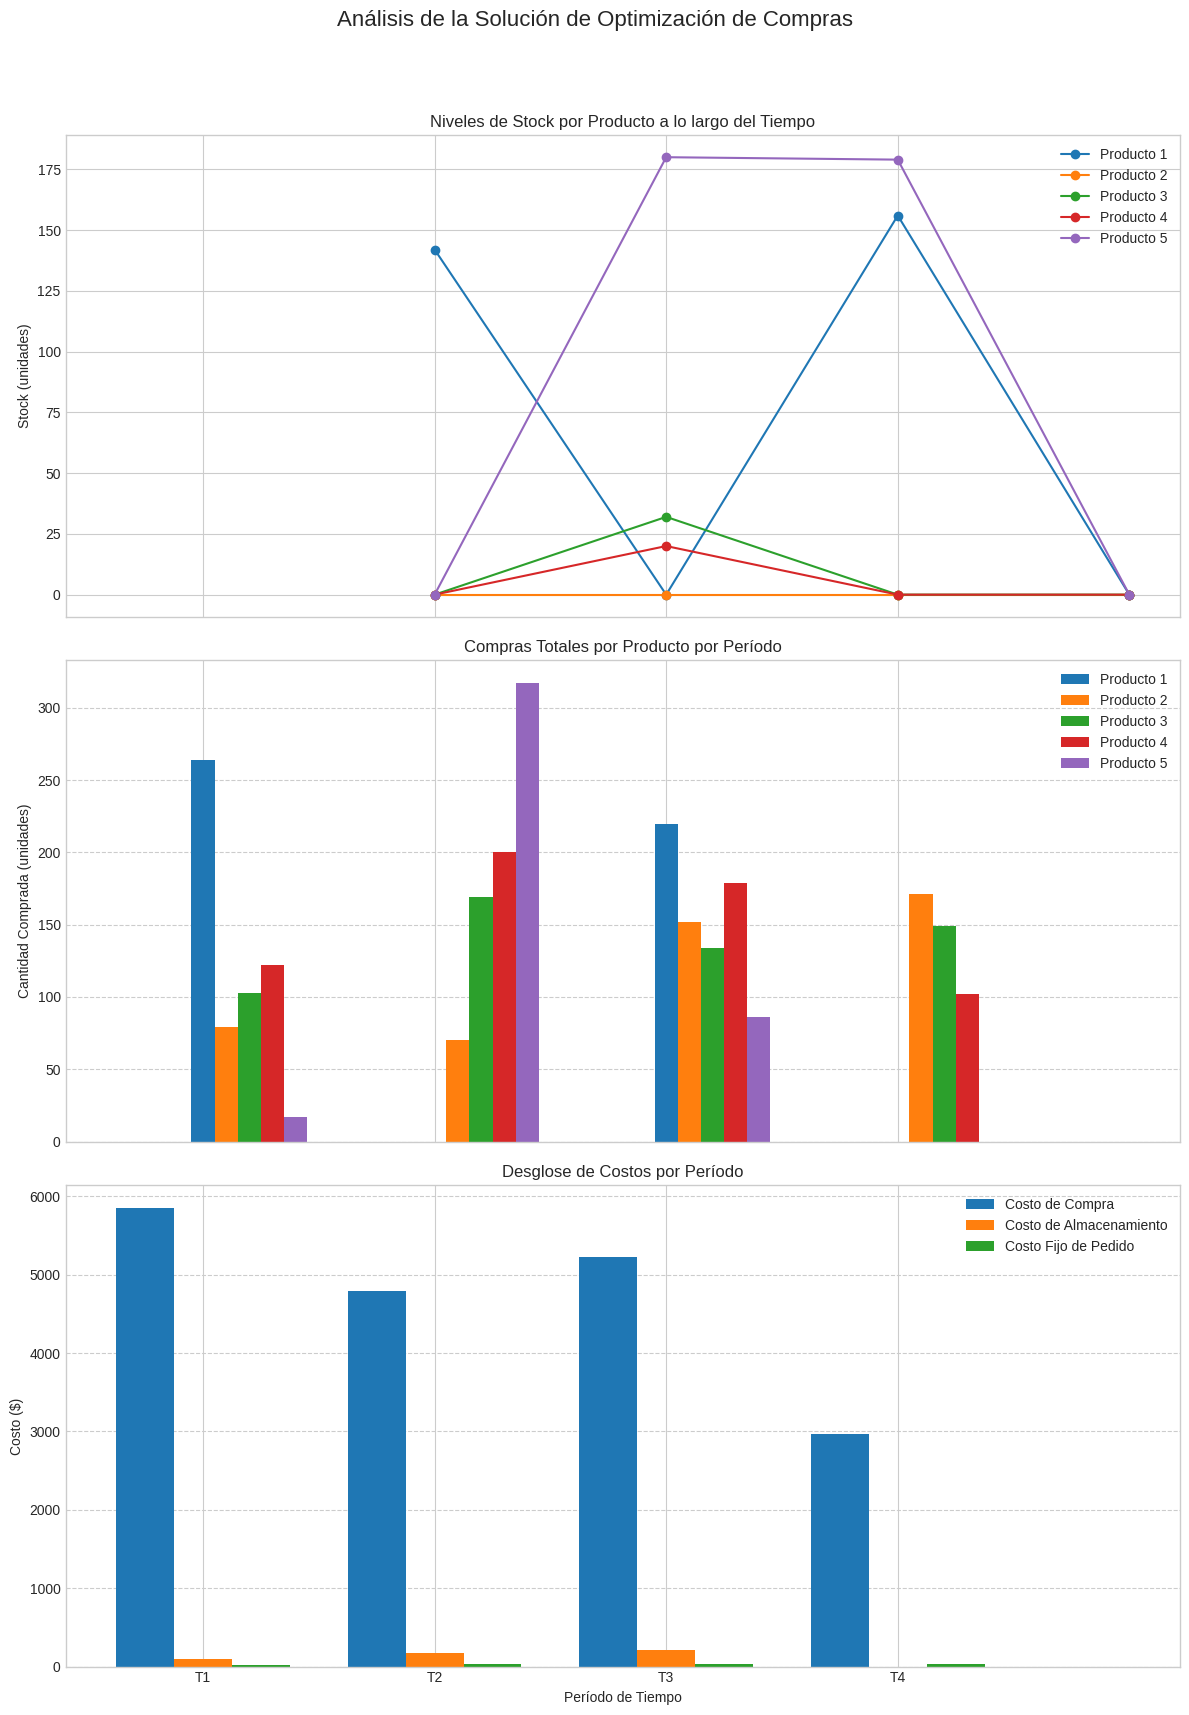

In [53]:
# ----------------------------------------------------------------------------------
# Script de optimización de compras usando POO.
#
# Versión corregida para asegurar que el conteo de variables refleje
# la eliminación de la variable de stock y se añade la visualización de resultados.
# ----------------------------------------------------------------------------------

# 1. Instalación de librerías y solver (con Gurobi de prueba)
import sys
import os
import time
import numpy as np
import pandas as pd
import pulp

# Se intenta importar matplotlib para las visualizaciones.
try:
    import matplotlib.pyplot as plt
    print("Matplotlib ya está instalado. ¡Excelente!")
except ImportError:
    try:
        print("Matplotlib no encontrado. Intentando instalar...")
        os.system("pip install matplotlib")
        import matplotlib.pyplot as plt
    except Exception as e:
        print(f"Advertencia: No se pudo instalar matplotlib. La funcionalidad de trazado estará desactivada. Error: {e}")
        plt = None

try:
    import gurobipy
    print("Gurobi ya está instalado y disponible. ¡Excelente!")
except ImportError:
    try:
        print("Gurobi no encontrado. Intentando instalar la versión de prueba...")
        os.system("pip install gurobipy")
        os.system("sudo apt-get install -y glpk-utils")
        os.system("pip install pulp pandas")
    except Exception as e:
        print(f"Error al instalar las dependencias. Por favor, revisa el mensaje de error: {e}", file=sys.stderr)
        sys.exit(1)


# ----------------------------------------------------------------------------------
# 2. Clases del Modelo de Optimización
# ----------------------------------------------------------------------------------

class ProblemParameters:
    """
    Clase para almacenar todos los datos y parámetros del problema de optimización.
    """
    def __init__(self, K: int, M: int, T: int):
        self.K = K  # Número de productos
        self.M = M  # Número de proveedores
        self.T = T  # Número de períodos de tiempo
        self.D = None                     # Matriz de demanda D[i][t]
        self.S_0 = None                   # Vector de stock inicial S_0[i]
        self.costo_compra = None          # Tensor de costo de compra C[i][j][t]
        self.costo_almacenamiento = None  # Vector de costo de almacenamiento H[i]
        self.S_capacidad_producto = None  # Matriz de capacidad de suministro S_cap[i][j]
        self.minimo_pedido = None         # Vector de cantidad mínima de pedido min_p[j]
        self.costo_fijo_pedido = None     # Matriz de costo fijo de pedido F[j][t]
        self.volumen_unitario = None      # Vector de volumen por unidad V[i]
        self.C_cap = None                 # Capacidad total del almacén C_cap

    def simulate_data(self, seed: int = 42):
        """Genera datos aleatorios para el problema."""
        np.random.seed(seed)
        self.D = np.random.randint(50, 200, size=(self.K, self.T))
        self.S_0 = np.random.randint(10, 50, size=self.K)
        self.costo_compra = np.random.uniform(5, 20, size=(self.K, self.M, self.T))
        self.costo_almacenamiento = np.random.uniform(0.5, 2, size=self.K)
        # La capacidad ahora es por producto y proveedor
        self.S_capacidad_producto = np.random.randint(100, 500, size=(self.K, self.M))

        # Valores de pedido mínimo más bajos para mayor factibilidad
        self.minimo_pedido = np.random.randint(20, 50, size=(self.M))

        self.costo_fijo_pedido = np.random.uniform(5, 25, size=(self.M, self.T))
        self.volumen_unitario = np.random.uniform(0.1, 0.5, size=self.K)
        self.C_cap = 1500

class PurchaseModel:
    """
    Clase para formular y resolver el modelo de optimización.
    """
    def __init__(self, params: ProblemParameters):
        self.params = params
        self.model = None
        self.p = None
        self.y = None
        self._formulate()

    def _formulate(self):
        """
        Formula el modelo con la función objetivo y las restricciones.
        Hemos eliminado la variable de stock, ya que puede ser expresada como
        una función de las compras y la demanda.
        """
        self.model = pulp.LpProblem("Plan_de_Compras_Optimo", pulp.LpMinimize)

        # Variables de decisión
        self.p = pulp.LpVariable.dicts("p", (range(self.params.K), range(self.params.M), range(self.params.T)), lowBound=0, cat='Continuous')
        self.y = pulp.LpVariable.dicts("y", (range(self.params.M), range(self.params.T)), cat='Binary')

        # Expresiones para el stock y la demanda acumulados
        def stock_expr(i, t):
            # Suma de stock inicial y las compras menos la demanda hasta el período t
            compras_acumuladas = pulp.lpSum(self.p[i][j][tau] for j in range(self.params.M) for tau in range(t + 1))
            demanda_acumulada = pulp.lpSum(self.params.D[i, tau] for tau in range(t + 1))
            return self.params.S_0[i] + compras_acumuladas - demanda_acumulada

        # Función objetivo: Minimizar el costo total
        coste_total_compra = pulp.lpSum(self.params.costo_compra[i, j, t] * self.p[i][j][t] for i in range(self.params.K) for j in range(self.params.M) for t in range(self.params.T))

        coste_total_almacenamiento = pulp.lpSum(self.params.costo_almacenamiento[i] * stock_expr(i, t) for i in range(self.params.K) for t in range(self.params.T))

        coste_fijo_total = pulp.lpSum(self.params.costo_fijo_pedido[j, t] * self.y[j][t] for j in range(self.params.M) for t in range(self.params.T))

        self.model += coste_total_compra + coste_total_almacenamiento + coste_fijo_total, "Costo Total"

        # Restricciones
        for i in range(self.params.K):
            for j in range(self.params.M):
                for t in range(self.params.T):
                    self.model += self.p[i][j][t] <= self.params.S_capacidad_producto[i, j] * self.y[j][t], f"Capacidad_Proveedor_Producto_{i}_{j}_{t}"

        for j in range(self.params.M):
            for t in range(self.params.T):
                self.model += pulp.lpSum(self.p[i][j][t] for i in range(self.params.K)) >= self.params.minimo_pedido[j] * self.y[j][t], f"Pedido_Min_{j}_{t}"

        # Restricción de capacidad de almacén
        for t in range(self.params.T):
            self.model += pulp.lpSum(stock_expr(i, t) * self.params.volumen_unitario[i] for i in range(self.params.K)) <= self.params.C_cap, f"Capacidad_Almacen_{t}"

        # Restricción de stock positivo
        for i in range(self.params.K):
            for t in range(self.params.T):
                self.model += stock_expr(i, t) >= 0, f"Stock_Positivo_{i}_{t}"

    def solve(self, print_summary: bool = True, time_limit: int = None):
        """
        Resuelve el modelo y devuelve un objeto Solution si es óptimo.

        Args:
            print_summary (bool): Si es True, imprime las métricas del modelo antes de resolver.
            time_limit (int): Límite de tiempo en segundos para el solver (opcional).
        """
        if print_summary:
            print("--- Verificando el tamaño del modelo ---")
            print(f"Número de variables: {self.model.numVariables()}")
            print(f"Número de restricciones: {self.model.numConstraints()}")
            print("---------------------------------------")

        try:
            print("--- Intentando resolver con Gurobi... ---")
            solver_kwargs = {'msg': 0}
            if time_limit is not None:
                solver_kwargs['timeLimit'] = time_limit

            self.model.solve(pulp.GUROBI(**solver_kwargs))

            if self.model.status != pulp.LpStatusOptimal and time_limit is None:
                raise Exception("Gurobi no encontró una solución óptima.")
        except Exception as e:
            print(f"ADVERTENCIA: Error o inviabilidad con Gurobi. Usando GLPK. Error: {e}")
            self.model.solve(pulp.GLPK(msg=0))

        if self.model.status == pulp.LpStatusOptimal:
            print("INFO: Solución óptima encontrada.")
            return Solution(self.model, self.p, self.y, self.params)
        else:
            print(f"El modelo no pudo ser resuelto. Estado: {pulp.LpStatus[self.model.status]}")
            return None


class Solution:
    """
    Clase para almacenar y presentar los resultados de una solución óptima.
    """
    def __init__(self, model, p, y, params):
        self.model = model
        self.p = p
        self.y = y
        self.params = params
        self.objective_value = pulp.value(model.objective) if model.status == pulp.LpStatusOptimal else 'N/A'
        self.status = pulp.LpStatus[model.status]

    def _calculate_stock_levels(self):
        """
        Calcula los niveles de stock para cada período a partir de las compras óptimas.
        """
        stock_levels = np.zeros((self.params.K, self.params.T))
        for i in range(self.params.K):
            for t in range(self.params.T):
                stock_previo = self.params.S_0[i] if t == 0 else stock_levels[i, t-1]
                compras_periodo = sum(pulp.value(self.p[i][j][t]) for j in range(self.params.M))
                demanda_periodo = self.params.D[i, t]
                stock_levels[i, t] = stock_previo + compras_periodo - demanda_periodo
        return stock_levels

    def display(self, message: str = ""):
        """Imprime los resultados en un formato legible y unificado, ordenado por tiempo."""
        print(f"\n--- {message} ---")
        if self.model.status == pulp.LpStatusOptimal:
            print(f"Estado de la solución: {self.status}")
            print(f"Costo total mínimo: ${self.objective_value:,.2f}")

            stock_levels = self._calculate_stock_levels()

            resultados_unificados = []
            for t in range(self.params.T):
                for i in range(self.params.K):
                    compras_detalle = []
                    costos_detalle = []
                    for j in range(self.params.M):
                        cantidad = pulp.value(self.p[i][j][t])
                        if cantidad is not None and cantidad > 1e-6:
                            compras_detalle.append(f"Pr{j+1}: {cantidad:.2f} unid.")
                            costos_detalle.append(f"Pr{j+1}: ${self.params.costo_compra[i, j, t]:.2f}")

                    if not compras_detalle:
                        compras_detalle.append("Ninguna")
                        costos_detalle.append("N/A")

                    stock_final = stock_levels[i, t]

                    resultados_unificados.append({
                        'Periodo': f'T{t+1}',
                        'Producto': f'P{i+1}',
                        'Demanda': self.params.D[i, t],
                        'Compras': "\n".join(compras_detalle),
                        'Stock Final': f"{stock_final:.2f}" if stock_final is not None else 'N/A',
                        'Costo Unitario': "\n".join(costos_detalle)
                    })

            df_resultados = pd.DataFrame(resultados_unificados)
            print("\nResumen del Plan de Compras y Almacenamiento:")
            print(df_resultados.to_string(index=False))

            print("\nResumen de Pedidos y Costos Fijos por Proveedor y Periodo:")
            pedidos_resumen = []
            for t in range(self.params.T):
                for j in range(self.params.M):
                    total_comprado = pulp.value(pulp.lpSum(self.p[i][j][t] for i in range(self.params.K)))
                    if total_comprado is not None and total_comprado > 1e-6:
                        pedidos_resumen.append({
                            'Periodo': f'T{t+1}',
                            'Proveedor': f'Pr{j+1}',
                            'Total Comprado': f'{total_comprado:.2f} unid.',
                            'Costo Fijo': f'${self.params.costo_fijo_pedido[j,t]:.2f}'
                        })
            if pedidos_resumen:
                df_pedidos = pd.DataFrame(pedidos_resumen)
                print(df_pedidos.to_string(index=False))
            else:
                print("No se realizaron pedidos con costo fijo en este plan.")
        else:
            print(f"--- No se pudo encontrar una solución. Estado: {self.status} ---")

    def plot_results(self):
        """
        Genera y muestra gráficos para visualizar los resultados del modelo.
        """
        if plt is None:
            print("Error: matplotlib no está instalado. No se pueden generar gráficos.")
            return

        print("\n--- Generando gráficos de resultados... ---")

        # Configuración del estilo de los gráficos
        plt.style.use('seaborn-v0_8-whitegrid')

        # Calcular los niveles de stock óptimos
        stock_levels = self._calculate_stock_levels()

        # Calcular compras por producto por período
        total_purchases = np.zeros((self.params.K, self.params.T))
        for i in range(self.params.K):
            for t in range(self.params.T):
                total_purchases[i, t] = sum(pulp.value(self.p[i][j][t]) for j in range(self.params.M))

        # Calcular los costos por período
        period_costs = {
            'Compra': np.zeros(self.params.T),
            'Almacenamiento': np.zeros(self.params.T),
            'Fijos': np.zeros(self.params.T)
        }
        for t in range(self.params.T):
            period_costs['Compra'][t] = sum(self.params.costo_compra[i, j, t] * pulp.value(self.p[i][j][t]) for i in range(self.params.K) for j in range(self.params.M))
            period_costs['Almacenamiento'][t] = sum(self.params.costo_almacenamiento[i] * stock_levels[i, t] for i in range(self.params.K))
            period_costs['Fijos'][t] = sum(self.params.costo_fijo_pedido[j, t] * pulp.value(self.y[j][t]) for j in range(self.params.M))

        # Crear figura con 3 subplots
        fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        fig.suptitle('Análisis de la Solución de Optimización de Compras', fontsize=16)

        # Gráfico 1: Niveles de stock por producto
        for i in range(self.params.K):
            axes[0].plot(range(1, self.params.T + 1), stock_levels[i, :], label=f'Producto {i+1}', marker='o')
        axes[0].set_title('Niveles de Stock por Producto a lo largo del Tiempo')
        axes[0].set_ylabel('Stock (unidades)')
        axes[0].legend()
        axes[0].grid(True)

        # Gráfico 2: Cantidad de compras por producto
        for i in range(self.params.K):
            axes[1].bar(np.arange(self.params.T) + i * 0.1, total_purchases[i, :], width=0.1, label=f'Producto {i+1}')
        axes[1].set_title('Compras Totales por Producto por Período')
        axes[1].set_ylabel('Cantidad Comprada (unidades)')
        axes[1].set_xticks(np.arange(self.params.T) + 0.1 * (self.params.K - 1) / 2)
        axes[1].set_xticklabels([f'T{t+1}' for t in range(self.params.T)])
        axes[1].legend()
        axes[1].grid(axis='y', linestyle='--')

        # Gráfico 3: Desglose de costos por período
        width = 0.25
        x = np.arange(self.params.T)
        axes[2].bar(x - width, period_costs['Compra'], width, label='Costo de Compra')
        axes[2].bar(x, period_costs['Almacenamiento'], width, label='Costo de Almacenamiento')
        axes[2].bar(x + width, period_costs['Fijos'], width, label='Costo Fijo de Pedido')
        axes[2].set_title('Desglose de Costos por Período')
        axes[2].set_xlabel('Período de Tiempo')
        axes[2].set_ylabel('Costo ($)')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels([f'T{t+1}' for t in range(self.params.T)])
        axes[2].legend()
        axes[2].grid(axis='y', linestyle='--')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# ----------------------------------------------------------------------------------
# 3. Pruebas unitarias
# ----------------------------------------------------------------------------------

def test_variable_demand_and_price():
    print("\n--- TEST: Demanda y Precio Variables ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[10, 100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 50]]])
    params.costo_almacenamiento = np.array([1])
    params.S_capacidad_producto = np.array([[500]])
    params.minimo_pedido = np.array([1])
    params.costo_fijo_pedido = np.array([[1, 1]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve(print_summary=False)
    assert sol is not None, "La solución no debería ser nula"
    assert pulp.value(sol.p[0][0][0]) > 0
    assert pulp.value(sol.p[0][0][1]) < 1e-6
    stock_levels = sol._calculate_stock_levels()
    assert abs(stock_levels[0, 1]) < 1e-6 # El stock al final del periodo 2 debería ser 0
    print("✓ Test Demanda y Precio Variables: PASADO.")


def test_wholesale_vs_standard_supplier():
    print("\n--- TEST: Proveedor Mayorista ---")
    params = ProblemParameters(K=1, M=2, T=1)
    params.D = np.array([[100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[2.0], [5.0]]])
    params.costo_almacenamiento = np.array([0])
    params.S_capacidad_producto = np.array([[1000, 100]])
    params.minimo_pedido = np.array([1000, 10])
    params.costo_fijo_pedido = np.array([[10], [10]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve(print_summary=False)
    assert sol is not None, "La solución no debería ser nula"
    assert pulp.value(sol.p[0][0][0]) < 1e-6
    assert abs(pulp.value(sol.p[0][1][0]) - params.D[0,0]) < 1e-6
    print("✓ Test Proveedor Mayorista: PASADO.")


def test_zero_storage_capacity():
    print("\n--- TEST: Capacidad de Almacenamiento Cero ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[100, 150]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 10]]])
    params.costo_almacenamiento = np.array([100])
    params.S_capacidad_producto = np.array([[500]])
    params.minimo_pedido = np.array([1])
    params.costo_fijo_pedido = np.array([[1, 1]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 0

    model = PurchaseModel(params)
    sol = model.solve(print_summary=False)
    assert sol is not None, "La solución no debería ser nula"
    assert abs(pulp.value(sol.p[0][0][0]) - params.D[0, 0]) < 1e-6
    assert abs(pulp.value(sol.p[0][0][1]) - params.D[0, 1]) < 1e-6
    stock_levels = sol._calculate_stock_levels()
    assert abs(stock_levels[0, 0]) < 1e-6
    print("✓ Test Capacidad de Almacenamiento Cero: PASADO.")


def test_liquidation_scenario():
    print("\n--- TEST: Escenario de Liquidación ---")
    params = ProblemParameters(K=1, M=1, T=1)
    params.D = np.array([[50]])
    params.S_0 = np.array([50])
    params.costo_compra = np.array([[[10]]])
    params.costo_almacenamiento = np.array([1])
    params.S_capacidad_producto = np.array([[500]])
    params.minimo_pedido = np.array([1])
    params.costo_fijo_pedido = np.array([[1]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve(print_summary=False)
    assert sol is not None, "La solución no debería ser nula"
    assert pulp.value(sol.p[0][0][0]) < 1e-6
    stock_levels = sol._calculate_stock_levels()
    assert abs(stock_levels[0, 0]) < 1e-6
    print("✓ Test Escenario de Liquidación: PASADO.")

def run_performance_test(num_products, num_providers, num_periods, time_limit_sec=60):
    """
    Realiza una prueba de rendimiento del modelo a gran escala.

    Args:
        num_products (int): Número de productos.
        num_providers (int): Número de proveedores.
        num_periods (int): Número de períodos.
        time_limit_sec (int): Límite de tiempo en segundos para el solver.
    """
    print(f"\n--- TEST DE RENDIMIENTO: {num_products} productos, {num_providers} proveedores, {num_periods} períodos ---")
    try:
        params = ProblemParameters(num_products, num_providers, num_periods)
        params.simulate_data(seed=123)
        model = PurchaseModel(params)

        start_time = time.time()
        sol = model.solve(print_summary=True, time_limit=time_limit_sec)
        end_time = time.time()

        if sol:
            print(f"✓ TEST DE RENDIMIENTO: Finalizado en {end_time - start_time:.2f} segundos.")
            print(f"Estado del solver: {sol.status}")
            print(f"Costo Total: ${sol.objective_value:,.2f}")
        else:
            print(f"✖ TEST DE RENDIMIENTO FALLIDO: No se encontró solución en el tiempo límite.")
    except Exception as e:
        print(f"✖ TEST DE RENDIMIENTO FALLIDO: Error durante la ejecución - {e}")

def run_all_tests():
    print("\n==============================================")
    print("       Ejecutando Pruebas Unitarias del Modelo")
    print("==============================================")
    test_variable_demand_and_price()
    test_wholesale_vs_standard_supplier()
    test_zero_storage_capacity()
    test_liquidation_scenario()

    print("\n==============================================")
    print("           Iniciando Prueba de Rendimiento")
    print("==============================================")
    run_performance_test(
        num_products=10,
        num_providers=10,
        num_periods=10,
        time_limit_sec=60
    )
    print("\n==============================================")
    print("       Todas las pruebas han finalizado.")
    print("==============================================")

if __name__ == "__main__":
    run_all_tests()
    print("--- 1. Ejecutando el caso general (simulado) ---")
    K_general, M_general, T_general = 5, 3, 4
    params_general = ProblemParameters(K_general, M_general, T_general)
    params_general.simulate_data()
    model_general = PurchaseModel(params_general)
    solution_general = model_general.solve()
    if solution_general:
        solution_general.display(message="Solución del Caso General")
        solution_general.plot_results()
    else:
        print("No se pudo encontrar una solución factible para el caso general.")
